In [ ]:
using Pkg
Pkg.activate(".")
using Revise

using Audio911
using PyCall
librosa = pyimport("librosa")

## Audio features extraction function

In [10]:
nan_replacer!(x::AbstractArray{Float64}) = replace!(x, NaN => 0.0)

function afe(audio::Audio;
    # -------------------------------- parameters -------------------------------- #
    # audio module
    sr = audio.sr,
    norm = true,
    speech_detection = false,
    # stft module
    stft_length = 1024,
    win_type = (:hann, :periodic),
    win_length = 1024,
    overlap_length = 512,
    stft_norm = :power,                      # :power, :magnitude, :pow2mag
    # mel filterbank module
    nbands = 26,
    scale = :mel_htk  ,                      # :mel_htk, :mel_slaney, :erb, :bark
    melfb_norm = :bandwidth,                 # :bandwidth, :area, :none
    freq_range = (0, round(Int, audio.sr / 2)),
    # mel spectrogram module
    db_scale = false,
    # mfcc module
    ncoeffs = 13,
    rectification = :log,                    # :log, :cubic_root
    dither = true,
)

    # --------------------------------- functions -------------------------------- #
    stftspec = get_stft(
        audio=audio,
        stft_length=stft_length,
        win_type=win_type,
        win_length=win_length,
        overlap_length=overlap_length,
        norm=stft_norm
    );

    # mel filterbank module
    melfb = get_melfb(
        stft=stftspec,
        nbands=nbands,
        scale=scale,
        norm=melfb_norm,
        freq_range=freq_range
    );

    # mel spectrogram module
    melspec =  get_melspec(
        stft=stftspec,
        fbank=melfb,
        db_scale=db_scale
    );

    # mfcc module
    mfccspec = get_mfcc(
        source=melspec,
        ncoeffs=ncoeffs,
        rectification=rectification,
        dither=dither,
    )

    return melspec, mfccspec
end

afe (generic function with 1 method)

## Load audiofile

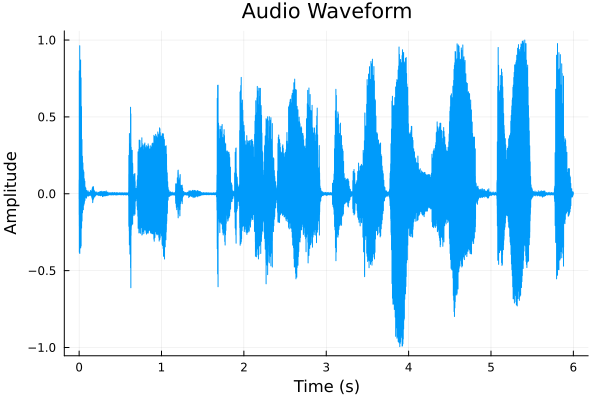

In [3]:
TESTPATH = joinpath(dirname(pathof(Audio911)), "..", "test")
TESTFILE = "common_voice_en_23616312.wav"
# TESTFILE = "104_1b1_Al_sc_Litt3200_4.wav"
wavfile = joinpath(TESTPATH, TESTFILE)

sr = 8000
audio = load_audio(file=wavfile, sr=sr, norm=true);
plot(audio)

## Mel spectrogram & Mfcc features extraction

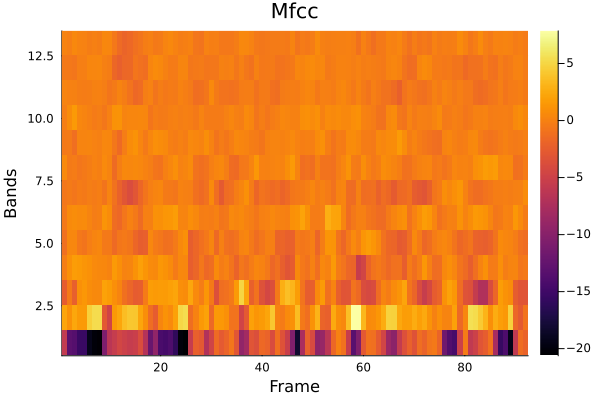

In [11]:
n_mel_bands = 26
melspec, mfccspec = afe(audio; nbands=n_mel_bands)
display(mfccspec)

## Perform librosa inverse mfcc > mel spectrogram

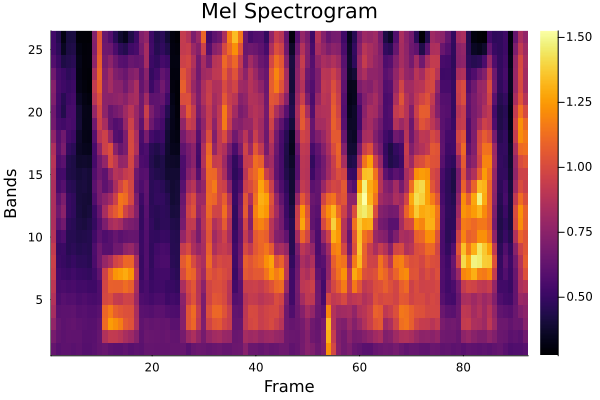

In [13]:
inv_mfcc = librosa.feature.inverse.mfcc_to_mel(mfcc = mfccspec.mfcc, n_mels=26)
reconstructed_spec = MelSpec(
    sr = audio.sr,
    nbands = n_mel_bands,
    spec = inv_mfcc,
    freq = melspec.freq
)
display(reconstructed_spec)

## Original mel spectrogram comparision

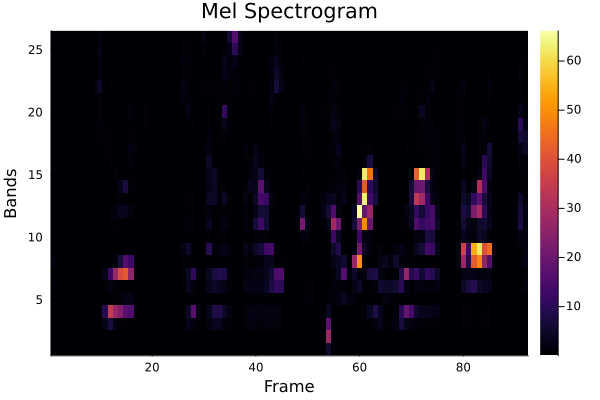

In [14]:
display(melspec)